# PySpark Online Retail II Dataset Analysis

This notebook demonstrates how to load and analyze the Online Retail II dataset using PySpark in Google Colab.


## 1. Install Required Packages

First, install PySpark and related dependencies in Google Colab.


In [ ]:
# Install required packages
%pip install pyspark pandas openpyxl


## 2. Import Libraries and Initialize Spark Session


In [ ]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, sum as spark_sum, count, when, isnan, isnull, desc, min as spark_min, max as spark_max
from pyspark.sql import functions as F
import pandas as pd

# Initialize Spark session
# Configure Spark for both local and Colab environments
spark = SparkSession.builder \
    .appName("OnlineRetailAnalysis") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.maxRecordsPerBatch", "10000") \
    .config("spark.driver.memory", "2g") \
    .config("spark.executor.memory", "2g") \
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "true") \
    .config("spark.python.worker.timeout", "300") \
    .config("spark.python.worker.reuse", "true") \
    .getOrCreate()

# Set log level to reduce output noise
spark.sparkContext.setLogLevel("WARN")

print("Spark session initialized successfully!")
print(f"Spark version: {spark.version}")


Spark session initialized successfully!
Spark version: 4.0.1


## 3. Load Data from GitHub

Since PySpark cannot directly read Excel files, we use pandas to read from GitHub and then convert to Spark DataFrame.


In [15]:
# Use pandas to read Excel file from GitHub
print("Reading Excel file from GitHub...")

# GitHub repository information
github_user = "Hachi630"
github_repo = "BDAS"
file_path = "online_retail_II.xlsx"

# Construct GitHub raw URL
github_url = f"https://raw.githubusercontent.com/{github_user}/{github_repo}/main/{file_path}"

# Read Excel file with multiple sheets
print("Loading data from both sheets (2009-2010 and 2010-2011)...")
excel_data = pd.read_excel(github_url, sheet_name=None)  # Read all sheets

# Get the two sheets
sheet_2009_2010 = excel_data['Year 2009-2010']
sheet_2010_2011 = excel_data['Year 2010-2011']

print(f"2009-2010 data shape: {sheet_2009_2010.shape}")
print(f"2010-2011 data shape: {sheet_2010_2011.shape}")

# Combine both datasets
pandas_df = pd.concat([sheet_2009_2010, sheet_2010_2011], ignore_index=True)
print(f"Combined data shape: {pandas_df.shape}")

# Convert pandas DataFrame to Spark DataFrame
# Ensure DataFrame is named df for consistency
df = spark.createDataFrame(pandas_df)

print("Data successfully loaded from GitHub into Spark DataFrame!")


Reading Excel file from GitHub...
Loading data from both sheets (2009-2010 and 2010-2011)...
2009-2010 data shape: (525461, 8)
2010-2011 data shape: (541910, 8)
Combined data shape: (1067371, 8)


d:\anaconda3\Lib\site-packages\pyspark\sql\pandas\conversion.py:425: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Could not convert 'C489449' with type str: tried to convert to int64
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Data successfully loaded from GitHub into Spark DataFrame!


## 4. Individual Table Analysis

Analyze each table separately before combining.


In [16]:
# Analyze individual tables
print("=== Individual Table Analysis ===")

print("\n--- 2009-2010 Data ---")
print(f"Shape: {sheet_2009_2010.shape}")
print(f"Columns: {list(sheet_2009_2010.columns)}")
print("First 3 rows:")
print(sheet_2009_2010.head(3))

print("\n--- 2010-2011 Data ---")
print(f"Shape: {sheet_2010_2011.shape}")
print(f"Columns: {list(sheet_2010_2011.columns)}")
print("First 3 rows:")
print(sheet_2010_2011.head(3))

print("\n--- Combined Data Summary ---")
print(f"Total records: {len(pandas_df):,}")
print(f"Total columns: {len(pandas_df.columns)}")
print(f"Columns: {list(pandas_df.columns)}")


=== Individual Table Analysis ===

--- 2009-2010 Data ---
Shape: (525461, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
First 3 rows:
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  

--- 2010-2011 Data ---
Shape: (541910, 8)
Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']
First 3 rows:
  Invoice StockCode                         Description  Quantity  \
0  536365    85123A  WHITE HANGING HEART

## 5. Check Data Dimensions

Determine the number of rows and columns in the combined dataset.


In [17]:
# Check data dimensions with error handling
print("=== Data Dimension Information ===")

# Get row count with error handling
try:
    row_count = df.count()
    print(f"Dataset row count: {row_count:,}")
    USE_SPARK = True
except Exception as e:
    print(f"Error getting row count with Spark: {e}")
    print("Using pandas DataFrame for all analysis...")
    row_count = len(pandas_df)
    print(f"Dataset row count (from pandas): {row_count:,}")
    USE_SPARK = False

# Get column count
if USE_SPARK:
    column_count = len(df.columns)
    column_names = df.columns
else:
    column_count = len(pandas_df.columns)
    column_names = list(pandas_df.columns)

print(f"Dataset column count: {column_count}")
print(f"Column names: {column_names}")


=== Data Dimension Information ===
Error getting row count with Spark: An error occurred while calling o150.count.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 2 in stage 4.0 failed 1 times, most recent failure: Lost task 2.0 in stage 4.0 (TID 82) (windows10.microdone.cn executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:252)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:143)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:158)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:178)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:261)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:70)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:374)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:338)
	at org.

## 6. Complete Analysis with Error Handling

The following analysis will automatically detect if PySpark is working and use the appropriate method.


In [18]:
# Preview data - show first 5 rows
print("=== Data Preview (First 5 Rows) ===")
if USE_SPARK:
    df.show(5, truncate=False)
else:
    print(pandas_df.head())

# Print data schema to verify data types
print("\n=== Data Schema ===")
if USE_SPARK:
    df.printSchema()
else:
    print(pandas_df.dtypes)

# Display basic statistical summary for numeric columns
print("\n=== Numeric Columns Statistical Summary ===")
if USE_SPARK:
    df.describe().show()
else:
    print(pandas_df.describe())

# Check for missing values
print("\n=== Missing Values Check ===")
if USE_SPARK:
    missing_values = df.select([spark_sum(when(isnull(c) | isnan(c), 1).otherwise(0)).alias(c) for c in df.columns])
    missing_values.show()
else:
    missing_values = pandas_df.isnull().sum()
    print(missing_values)


=== Data Preview (First 5 Rows) ===
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

=== Data Schema ===
Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price       

In [19]:
# Check negative values in Quantity column (returns)
print("=== Quantity Column Analysis ===")
if USE_SPARK:
    quantity_stats = df.select(
        spark_min("Quantity").alias("Min Quantity"),
        spark_max("Quantity").alias("Max Quantity"),
        count(when(col("Quantity") < 0, 1)).alias("Return Records Count"),
        count(when(col("Quantity") > 0, 1)).alias("Normal Sales Records Count")
    )
    quantity_stats.show()
else:
    quantity_stats = {
        "Min Quantity": pandas_df['Quantity'].min(),
        "Max Quantity": pandas_df['Quantity'].max(),
        "Return Records Count": (pandas_df['Quantity'] < 0).sum(),
        "Normal Sales Records Count": (pandas_df['Quantity'] > 0).sum()
    }
    for key, value in quantity_stats.items():
        print(f"{key}: {value}")

# Check UnitPrice column range
print("\n=== UnitPrice Column Analysis ===")
if USE_SPARK:
    price_stats = df.select(
        spark_min("UnitPrice").alias("Min Unit Price"),
        spark_max("UnitPrice").alias("Max Unit Price"),
        count(when(col("UnitPrice") < 0, 1)).alias("Negative Price Records Count"),
        count(when(col("UnitPrice") == 0, 1)).alias("Zero Price Records Count")
    )
    price_stats.show()
else:
    price_stats = {
        "Min Unit Price": pandas_df['Price'].min(),
        "Max Unit Price": pandas_df['Price'].max(),
        "Negative Price Records Count": (pandas_df['Price'] < 0).sum(),
        "Zero Price Records Count": (pandas_df['Price'] == 0).sum()
    }
    for key, value in price_stats.items():
        print(f"{key}: {value}")


=== Quantity Column Analysis ===
Min Quantity: -80995
Max Quantity: 80995
Return Records Count: 22950
Normal Sales Records Count: 1044421

=== UnitPrice Column Analysis ===
Min Unit Price: -53594.36
Max Unit Price: 38970.0
Negative Price Records Count: 5
Zero Price Records Count: 6202


## 7. Exploratory Data Analysis (EDA)

Comprehensive analysis using PySpark with pandas/Matplotlib for visualization.


In [24]:
# Import additional libraries for EDA
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pyspark.sql import functions as F
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")


### 7.1 Key Counts Summary

Calculate basic totals and counts to understand the dataset scale.


In [23]:
# Calculate number of distinct products and customers
print("=== Key Dataset Metrics ===")

if USE_SPARK:
    # Calculate distinct counts using Spark
    unique_products = df.select("StockCode").distinct().count()
    unique_customers = df.select("Customer ID").distinct().count()
    
    # Calculate total revenue (sum of Quantity * Price)
    total_revenue = df.agg(F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]
    
    # Calculate total transactions
    total_transactions = df.count()
    
    print(f"Total Transactions: {total_transactions:,}")
    print(f"Unique Products (StockCode): {unique_products:,}")
    print(f"Unique Customers: {unique_customers:,}")
    print(f"Total Revenue: £{total_revenue:,.2f}")
    
else:
    # Calculate using pandas
    unique_products = pandas_df['StockCode'].nunique()
    unique_customers = pandas_df['Customer ID'].nunique()
    total_revenue = (pandas_df['Quantity'] * pandas_df['Price']).sum()
    total_transactions = len(pandas_df)
    
    print(f"Total Transactions: {total_transactions:,}")
    print(f"Unique Products (StockCode): {unique_products:,}")
    print(f"Unique Customers: {unique_customers:,}")
    print(f"Total Revenue: £{total_revenue:,.2f}")

# Additional metrics
if USE_SPARK:
    avg_order_value = df.agg(F.avg(F.col("Quantity") * F.col("Price")).alias("AvgOrderValue")).collect()[0]["AvgOrderValue"]
    print(f"Average Order Value: £{avg_order_value:.2f}")
else:
    avg_order_value = (pandas_df['Quantity'] * pandas_df['Price']).mean()
    print(f"Average Order Value: £{avg_order_value:.2f}")


=== Key Dataset Metrics ===
Total Transactions: 1,067,371
Unique Products (StockCode): 5,305
Unique Customers: 5,942
Total Revenue: £19,287,250.57
Average Order Value: £18.07


### 7.2 Sales Over Time Analysis

Investigate temporal trends by aggregating sales by month.


In [25]:
# Aggregate sales by month for trend analysis
print("=== Monthly Sales Analysis ===")

if USE_SPARK:
    # Create monthly aggregation using Spark
    monthly_sales = df.groupBy(F.year("InvoiceDate").alias("Year"), 
                               F.month("InvoiceDate").alias("Month")) \
                      .agg(F.sum("Quantity").alias("TotalQuantity"),
                           F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue"),
                           F.count("*").alias("TransactionCount")) \
                      .orderBy("Year", "Month")
    
    print("Monthly Sales Summary:")
    monthly_sales.show(24)  # Show 2 years of data
    
    # Convert to pandas for plotting
    monthly_pandas = monthly_sales.toPandas()
    
else:
    # Create monthly aggregation using pandas
    pandas_df['Year'] = pandas_df['InvoiceDate'].dt.year
    pandas_df['Month'] = pandas_df['InvoiceDate'].dt.month
    
    monthly_sales = pandas_df.groupby(['Year', 'Month']).agg({
        'Quantity': 'sum',
        'Price': lambda x: (pandas_df.loc[x.index, 'Quantity'] * x).sum(),
        'Invoice': 'count'
    }).rename(columns={'Quantity': 'TotalQuantity', 'Price': 'TotalRevenue', 'Invoice': 'TransactionCount'})
    
    monthly_sales = monthly_sales.reset_index().sort_values(['Year', 'Month'])
    print("Monthly Sales Summary:")
    print(monthly_sales.head(24))
    
    monthly_pandas = monthly_sales.copy()

# Create year-month string for better plotting
monthly_pandas['YearMonth'] = monthly_pandas['Year'].astype(str) + '-' + monthly_pandas['Month'].astype(str).str.zfill(2)


=== Monthly Sales Analysis ===
Monthly Sales Summary:
    Year  Month  TotalQuantity  TotalRevenue  TransactionCount
0   2009     12         420088    799847.110             45228
1   2010      1         375363    624032.892             31555
2   2010      2         368402    533091.426             29388
3   2010      3         489370    765848.761             41511
4   2010      4         351971    590580.432             34057
5   2010      5         364095    615322.830             35323
6   2010      6         388253    679786.610             39983
7   2010      7         302201    575236.360             33383
8   2010      8         451803    656776.340             33306
9   2010      9         478262    853650.431             42091
10  2010     10         601729   1045168.350             59098
11  2010     11         673856   1422654.642             78015
12  2010     12         508876   1126445.470             65004
13  2011      1         308966    560000.260             35147
1

<Figure size 1500x800 with 0 Axes>

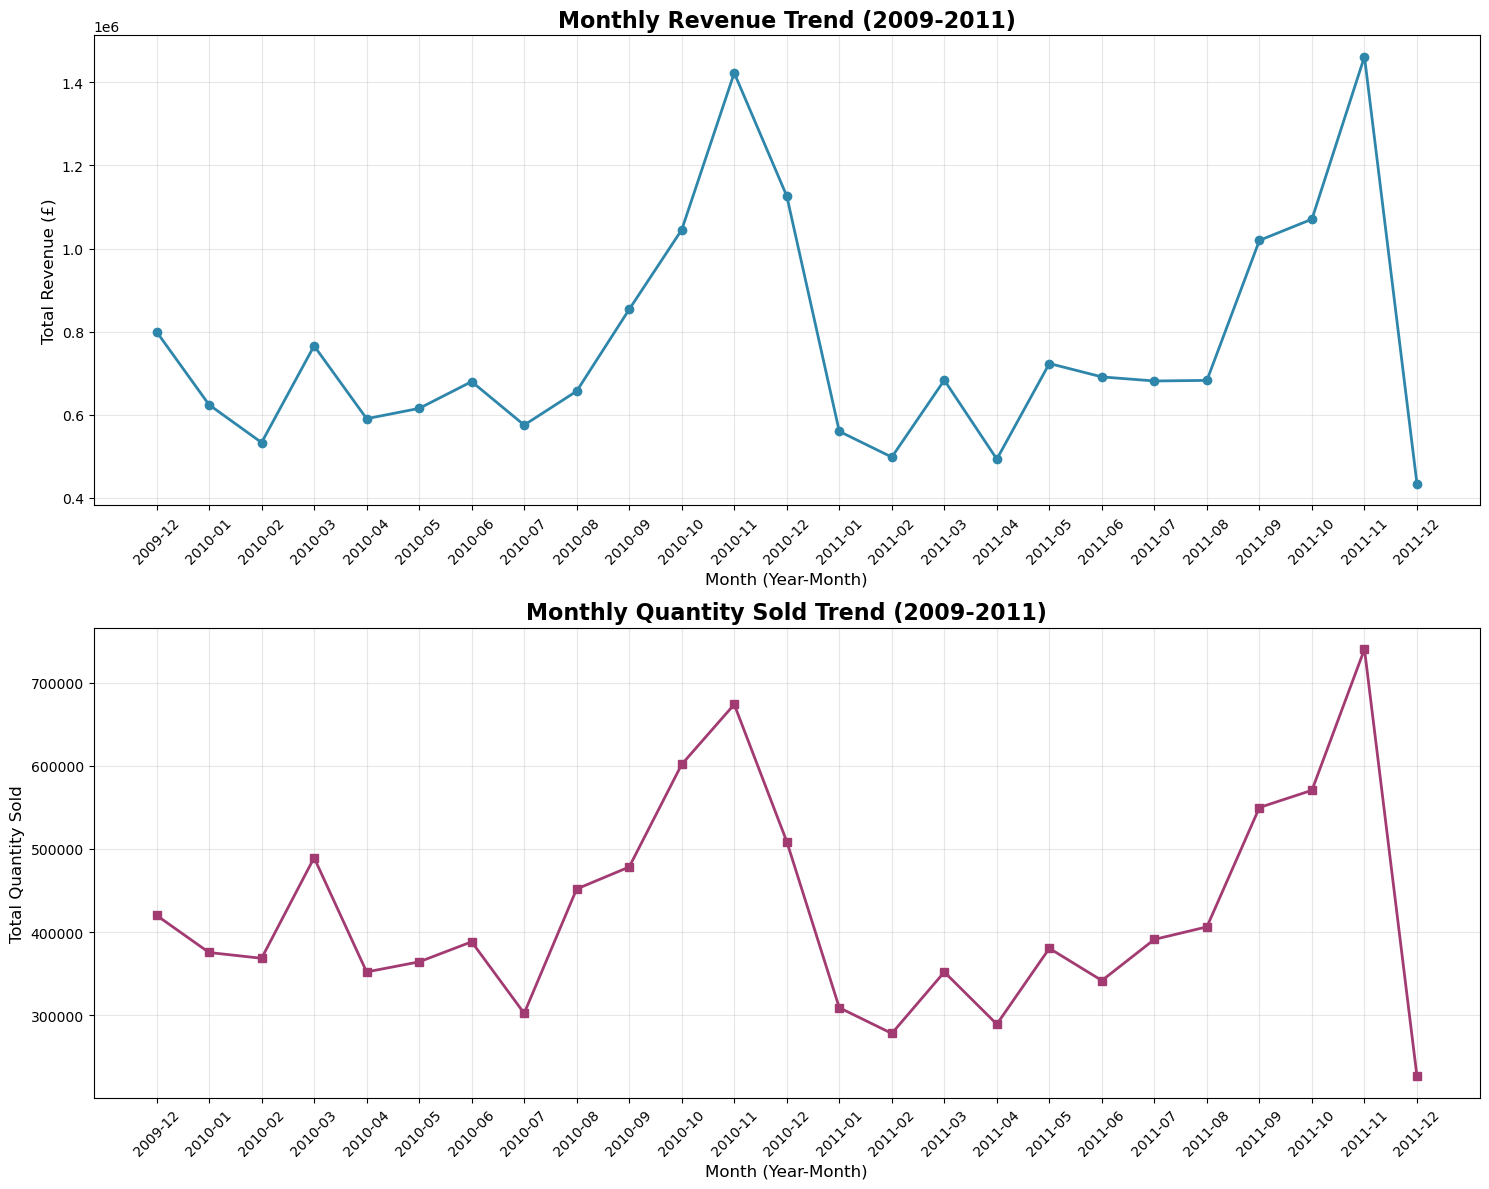


=== Temporal Insights ===
Peak revenue month: 2011-11 (£1,461,756.25)
Lowest revenue month: 2011-12 (£433,686.01)
Peak quantity month: 2011-11 (740,286 units)
Lowest quantity month: 2011-12 (226,334 units)


In [26]:
# Plot monthly sales trend
plt.figure(figsize=(15, 8))

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot 1: Monthly Revenue Trend
ax1.plot(monthly_pandas['YearMonth'], monthly_pandas['TotalRevenue'], 
         marker='o', linewidth=2, markersize=6, color='#2E86AB')
ax1.set_title('Monthly Revenue Trend (2009-2011)', fontsize=16, fontweight='bold')
ax1.set_xlabel('Month (Year-Month)', fontsize=12)
ax1.set_ylabel('Total Revenue (£)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Monthly Quantity Trend
ax2.plot(monthly_pandas['YearMonth'], monthly_pandas['TotalQuantity'], 
         marker='s', linewidth=2, markersize=6, color='#A23B72')
ax2.set_title('Monthly Quantity Sold Trend (2009-2011)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Month (Year-Month)', fontsize=12)
ax2.set_ylabel('Total Quantity Sold', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print insights
print("\n=== Temporal Insights ===")
print(f"Peak revenue month: {monthly_pandas.loc[monthly_pandas['TotalRevenue'].idxmax(), 'YearMonth']} (£{monthly_pandas['TotalRevenue'].max():,.2f})")
print(f"Lowest revenue month: {monthly_pandas.loc[monthly_pandas['TotalRevenue'].idxmin(), 'YearMonth']} (£{monthly_pandas['TotalRevenue'].min():,.2f})")
print(f"Peak quantity month: {monthly_pandas.loc[monthly_pandas['TotalQuantity'].idxmax(), 'YearMonth']} ({monthly_pandas['TotalQuantity'].max():,} units)")
print(f"Lowest quantity month: {monthly_pandas.loc[monthly_pandas['TotalQuantity'].idxmin(), 'YearMonth']} ({monthly_pandas['TotalQuantity'].min():,} units)")


### 7.3 Quantity Distribution Analysis

Examine the distribution of Quantity per transaction.


=== Quantity Distribution Analysis ===
Quantity Quartiles: Q1=1, Q2=3, Q3=10, 95th=30


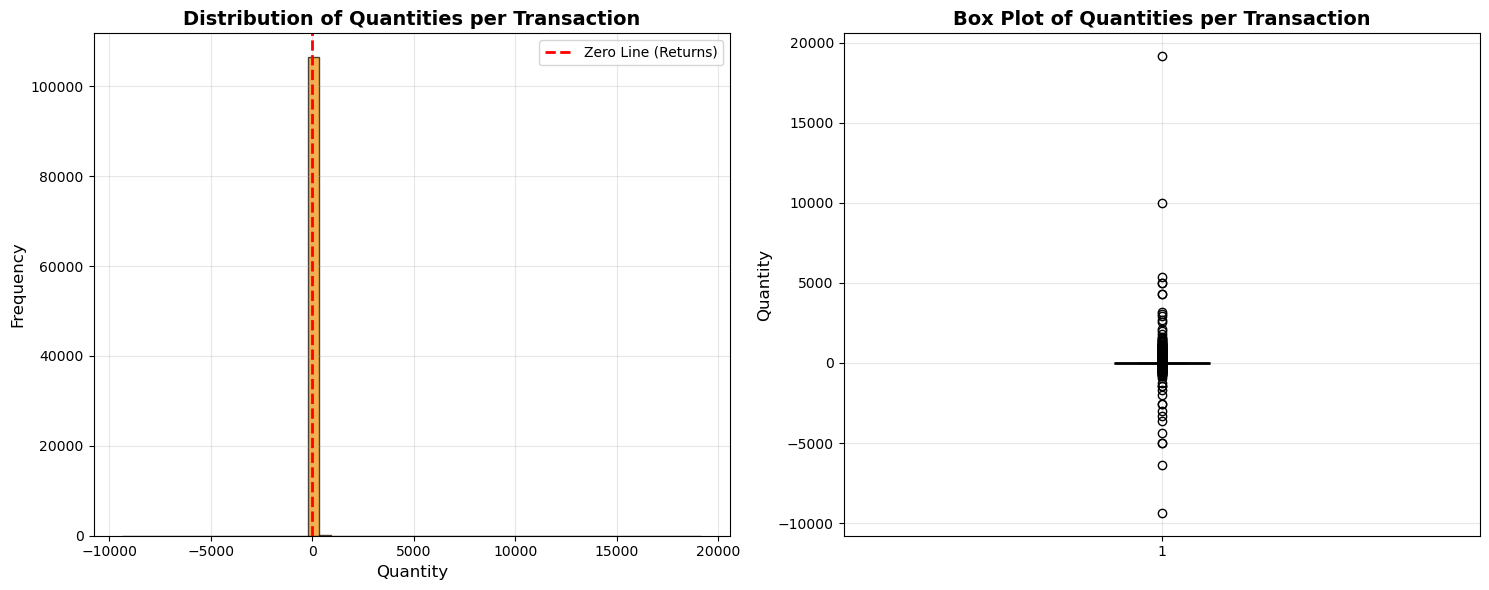


Quantity Statistics:
Min: -80995
Max: 80995
Mean: 9.94
Std Dev: 172.71

Returns Analysis:
Number of return transactions: 22,950
Percentage of returns: 2.15%


In [27]:
# Plot distribution of quantities per transaction
print("=== Quantity Distribution Analysis ===")

if USE_SPARK:
    # Get quartiles using Spark
    quartiles = df.approxQuantile("Quantity", [0.25, 0.5, 0.75, 0.95], 0.01)
    print(f"Quantity Quartiles: Q1={quartiles[0]:.0f}, Q2={quartiles[1]:.0f}, Q3={quartiles[2]:.0f}, 95th={quartiles[3]:.0f}")
    
    # Sample data for plotting (to avoid memory issues)
    quantities_sample = df.select("Quantity").sample(fraction=0.1, seed=42).toPandas()
    
else:
    # Get quartiles using pandas
    quartiles = pandas_df['Quantity'].quantile([0.25, 0.5, 0.75, 0.95])
    print(f"Quantity Quartiles: Q1={quartiles[0.25]:.0f}, Q2={quartiles[0.5]:.0f}, Q3={quartiles[0.75]:.0f}, 95th={quartiles[0.95]:.0f}")
    
    # Sample data for plotting
    quantities_sample = pandas_df['Quantity'].sample(frac=0.1, random_state=42)

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Histogram of quantities
ax1.hist(quantities_sample, bins=50, alpha=0.7, color='#F18F01', edgecolor='black')
ax1.set_title('Distribution of Quantities per Transaction', fontsize=14, fontweight='bold')
ax1.set_xlabel('Quantity', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Line (Returns)')
ax1.legend()

# Plot 2: Box plot
ax2.boxplot(quantities_sample, patch_artist=True, 
           boxprops=dict(facecolor='#C73E1D', alpha=0.7),
           medianprops=dict(color='black', linewidth=2))
ax2.set_title('Box Plot of Quantities per Transaction', fontsize=14, fontweight='bold')
ax2.set_ylabel('Quantity', fontsize=12)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional statistics
if USE_SPARK:
    quantity_stats = df.agg(F.min("Quantity").alias("Min"),
                           F.max("Quantity").alias("Max"),
                           F.mean("Quantity").alias("Mean"),
                           F.stddev("Quantity").alias("StdDev")).collect()[0]
    print(f"\nQuantity Statistics:")
    print(f"Min: {quantity_stats['Min']}")
    print(f"Max: {quantity_stats['Max']}")
    print(f"Mean: {quantity_stats['Mean']:.2f}")
    print(f"Std Dev: {quantity_stats['StdDev']:.2f}")
else:
    print(f"\nQuantity Statistics:")
    print(f"Min: {pandas_df['Quantity'].min()}")
    print(f"Max: {pandas_df['Quantity'].max()}")
    print(f"Mean: {pandas_df['Quantity'].mean():.2f}")
    print(f"Std Dev: {pandas_df['Quantity'].std():.2f}")

# Analyze returns (negative quantities)
if USE_SPARK:
    returns_count = df.filter(F.col("Quantity") < 0).count()
    returns_percentage = (returns_count / df.count()) * 100
else:
    returns_count = (pandas_df['Quantity'] < 0).sum()
    returns_percentage = (returns_count / len(pandas_df)) * 100

print(f"\nReturns Analysis:")
print(f"Number of return transactions: {returns_count:,}")
print(f"Percentage of returns: {returns_percentage:.2f}%")


### 7.4 Top and Bottom Products Analysis

Identify the best-selling and slowest-selling products.


=== Top Products Analysis ===
Top 10 Products by Quantity Sold:
           TotalQuantity  TotalRevenue  TransactionCount
StockCode                                               
84077             108545      24898.22              1056
85123A             96066     253720.02              5829
85099B             95739     181278.51              4216
21212              95450      52447.54              3318
84879              80705     131413.85              2960
22197              79363      80300.07              2549
17003              70700      14743.41               483
21977              56575      28373.68              2092
84991              54366      27216.27              2271
22492              45384      28863.54               763


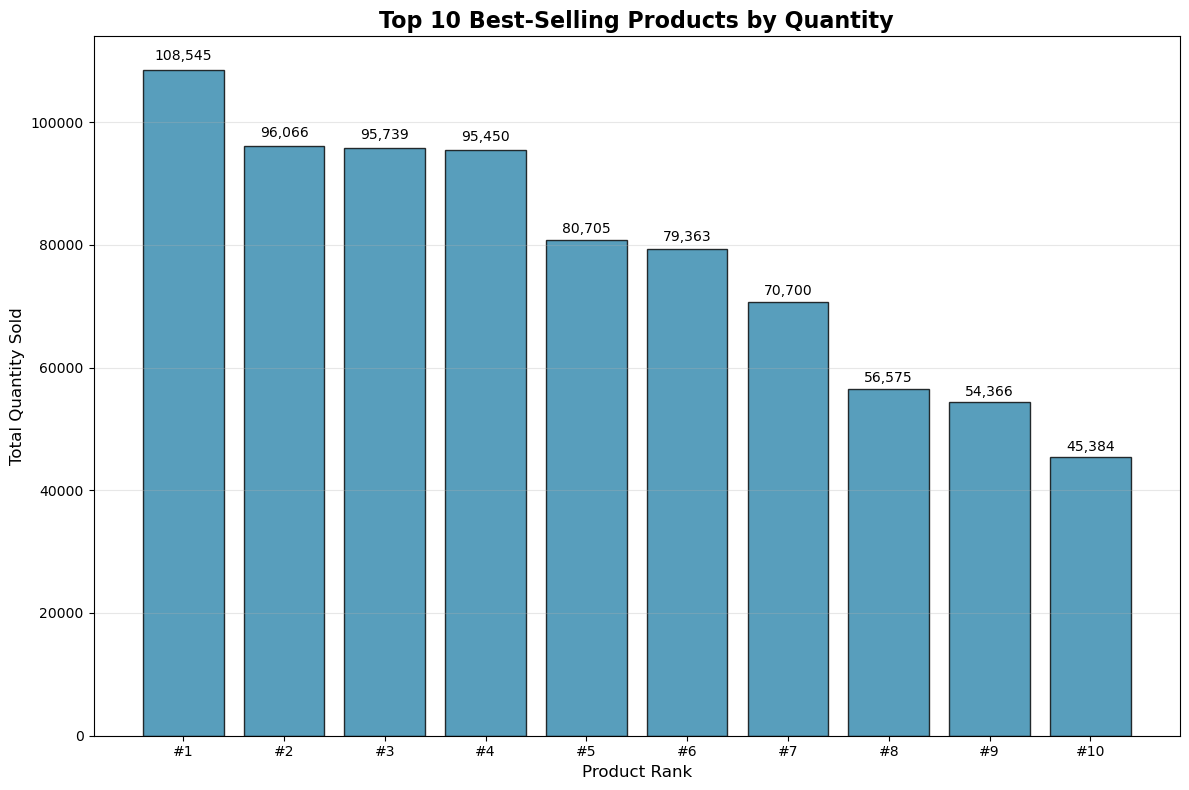


Top 10 Product Details:
1. StockCode: 84077 | Quantity: 108,545.0 | Revenue: £24,898.22
2. StockCode: 85123A | Quantity: 96,066.0 | Revenue: £253,720.02
3. StockCode: 85099B | Quantity: 95,739.0 | Revenue: £181,278.51
4. StockCode: 21212 | Quantity: 95,450.0 | Revenue: £52,447.54
5. StockCode: 84879 | Quantity: 80,705.0 | Revenue: £131,413.85
6. StockCode: 22197 | Quantity: 79,363.0 | Revenue: £80,300.07
7. StockCode: 17003 | Quantity: 70,700.0 | Revenue: £14,743.41
8. StockCode: 21977 | Quantity: 56,575.0 | Revenue: £28,373.68
9. StockCode: 84991 | Quantity: 54,366.0 | Revenue: £27,216.27
10. StockCode: 22492 | Quantity: 45,384.0 | Revenue: £28,863.54


In [28]:
# Identify top 10 best-selling products and their sales
print("=== Top Products Analysis ===")

if USE_SPARK:
    # Aggregate by StockCode using Spark
    product_sales = df.groupBy("StockCode").agg(
        F.sum("Quantity").alias("TotalQuantity"),
        F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue"),
        F.count("*").alias("TransactionCount")
    )
    
    # Get top 10 products by quantity
    top_products = product_sales.orderBy(F.desc("TotalQuantity")).limit(10)
    print("Top 10 Products by Quantity Sold:")
    top_products.show()
    
    # Convert to pandas for plotting
    top_products_pandas = top_products.toPandas()
    
else:
    # Aggregate by StockCode using pandas
    product_sales = pandas_df.groupby('StockCode').agg({
        'Quantity': 'sum',
        'Price': lambda x: (pandas_df.loc[x.index, 'Quantity'] * x).sum(),
        'Invoice': 'count'
    }).rename(columns={'Quantity': 'TotalQuantity', 'Price': 'TotalRevenue', 'Invoice': 'TransactionCount'})
    
    # Get top 10 products by quantity
    top_products_pandas = product_sales.nlargest(10, 'TotalQuantity')
    print("Top 10 Products by Quantity Sold:")
    print(top_products_pandas)

# Plot top products
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(top_products_pandas)), top_products_pandas['TotalQuantity'], 
               color='#2E86AB', alpha=0.8, edgecolor='black')
plt.title('Top 10 Best-Selling Products by Quantity', fontsize=16, fontweight='bold')
plt.xlabel('Product Rank', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.xticks(range(len(top_products_pandas)), [f"#{i+1}" for i in range(len(top_products_pandas))])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Show product codes and descriptions
print("\nTop 10 Product Details:")
for i, (idx, row) in enumerate(top_products_pandas.iterrows(), 1):
    print(f"{i}. StockCode: {idx} | Quantity: {row['TotalQuantity']:,} | Revenue: £{row['TotalRevenue']:,.2f}")


In [ ]:
# Identify a sample of low-selling products
print("\n=== Bottom Products Analysis ===")

if USE_SPARK:
    # Get bottom 10 products by quantity (excluding returns)
    bottom_products = product_sales.filter(F.col("TotalQuantity") > 0).orderBy(F.asc("TotalQuantity")).limit(10)
    print("Bottom 10 Products by Quantity Sold:")
    bottom_products.show()
    
    # Convert to pandas
    bottom_products_pandas = bottom_products.toPandas()
    
else:
    # Get bottom 10 products by quantity (excluding returns)
    bottom_products_pandas = product_sales[product_sales['TotalQuantity'] > 0].nsmallest(10, 'TotalQuantity')
    print("Bottom 10 Products by Quantity Sold:")
    print(bottom_products_pandas)

# Plot bottom products
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(bottom_products_pandas)), bottom_products_pandas['TotalQuantity'], 
               color='#A23B72', alpha=0.8, edgecolor='black')
plt.title('Bottom 10 Slowest-Selling Products by Quantity', fontsize=16, fontweight='bold')
plt.xlabel('Product Rank', fontsize=12)
plt.ylabel('Total Quantity Sold', fontsize=12)
plt.xticks(range(len(bottom_products_pandas)), [f"#{i+1}" for i in range(len(bottom_products_pandas))])
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Show bottom product details
print("\nBottom 10 Product Details:")
for i, (idx, row) in enumerate(bottom_products_pandas.iterrows(), 1):
    print(f"{i}. StockCode: {idx} | Quantity: {row['TotalQuantity']:,} | Revenue: £{row['TotalRevenue']:,.2f}")

# Analyze product performance distribution
if USE_SPARK:
    total_products = product_sales.count()
    high_performers = product_sales.filter(F.col("TotalQuantity") > 1000).count()
    medium_performers = product_sales.filter((F.col("TotalQuantity") > 100) & (F.col("TotalQuantity") <= 1000)).count()
    low_performers = product_sales.filter(F.col("TotalQuantity") <= 100).count()
else:
    total_products = len(product_sales)
    high_performers = len(product_sales[product_sales['TotalQuantity'] > 1000])
    medium_performers = len(product_sales[(product_sales['TotalQuantity'] > 100) & (product_sales['TotalQuantity'] <= 1000)])
    low_performers = len(product_sales[product_sales['TotalQuantity'] <= 100])

print(f"\n=== Product Performance Distribution ===")
print(f"Total Products: {total_products:,}")
print(f"High Performers (>1000 units): {high_performers:,} ({high_performers/total_products*100:.1f}%)")
print(f"Medium Performers (100-1000 units): {medium_performers:,} ({medium_performers/total_products*100:.1f}%)")
print(f"Low Performers (≤100 units): {low_performers:,} ({low_performers/total_products*100:.1f}%)")


### 7.5 Geographical Analysis

Evaluate sales by country to understand market distribution.


In [ ]:
# Analyze sales by country
print("=== Geographical Sales Analysis ===")

if USE_SPARK:
    # Group by Country using Spark
    country_sales = df.groupBy("Country").agg(
        F.count("*").alias("NumTransactions"),
        F.sum(F.col("Quantity") * F.col("Price")).alias("TotalRevenue"),
        F.sum("Quantity").alias("TotalQuantity"),
        F.countDistinct("Customer ID").alias("UniqueCustomers")
    ).orderBy(F.desc("TotalRevenue"))
    
    print("Top 10 Countries by Revenue:")
    country_sales.show(10)
    
    # Convert to pandas for plotting
    country_pandas = country_sales.toPandas()
    
else:
    # Group by Country using pandas
    country_sales = pandas_df.groupby('Country').agg({
        'Invoice': 'count',
        'Price': lambda x: (pandas_df.loc[x.index, 'Quantity'] * x).sum(),
        'Quantity': 'sum',
        'Customer ID': 'nunique'
    }).rename(columns={'Invoice': 'NumTransactions', 'Price': 'TotalRevenue', 
                      'Quantity': 'TotalQuantity', 'Customer ID': 'UniqueCustomers'})
    
    country_pandas = country_sales.sort_values('TotalRevenue', ascending=False)
    print("Top 10 Countries by Revenue:")
    print(country_pandas.head(10))

# Create visualizations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Top 10 Countries by Revenue
top_countries = country_pandas.head(10)
bars1 = ax1.bar(range(len(top_countries)), top_countries['TotalRevenue'], 
                color='#2E86AB', alpha=0.8, edgecolor='black')
ax1.set_title('Top 10 Countries by Revenue', fontsize=14, fontweight='bold')
ax1.set_xlabel('Country', fontsize=12)
ax1.set_ylabel('Total Revenue (£)', fontsize=12)
ax1.set_xticks(range(len(top_countries)))
ax1.set_xticklabels(top_countries['Country'], rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'£{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Plot 2: Top 10 Countries by Transaction Count
bars2 = ax2.bar(range(len(top_countries)), top_countries['NumTransactions'], 
                color='#A23B72', alpha=0.8, edgecolor='black')
ax2.set_title('Top 10 Countries by Transaction Count', fontsize=14, fontweight='bold')
ax2.set_xlabel('Country', fontsize=12)
ax2.set_ylabel('Number of Transactions', fontsize=12)
ax2.set_xticks(range(len(top_countries)))
ax2.set_xticklabels(top_countries['Country'], rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Market concentration analysis
uk_revenue = country_pandas[country_pandas['Country'] == 'United Kingdom']['TotalRevenue'].iloc[0]
total_revenue = country_pandas['TotalRevenue'].sum()
uk_percentage = (uk_revenue / total_revenue) * 100

print(f"\n=== Market Concentration Analysis ===")
print(f"UK Revenue: £{uk_revenue:,.2f}")
print(f"Total Revenue: £{total_revenue:,.2f}")
print(f"UK Market Share: {uk_percentage:.1f}%")

# Top 5 countries analysis
print(f"\nTop 5 Countries Analysis:")
for i, (idx, row) in enumerate(country_pandas.head(5).iterrows(), 1):
    market_share = (row['TotalRevenue'] / total_revenue) * 100
    print(f"{i}. {idx}: £{row['TotalRevenue']:,.2f} ({market_share:.1f}%) | {row['NumTransactions']:,} transactions | {row['UniqueCustomers']:,} customers")


### 7.6 EDA Summary

Key findings from the exploratory data analysis.


In [ ]:
print("=== EDA Summary and Key Findings ===")
print("\n📊 DATASET SCALE:")
print(f"• Total Transactions: {row_count:,}")
print(f"• Unique Products: {unique_products:,}")
print(f"• Unique Customers: {unique_customers:,}")
print(f"• Total Revenue: £{total_revenue:,.2f}")
print(f"• Average Order Value: £{avg_order_value:.2f}")

print("\n📈 TEMPORAL TRENDS:")
print(f"• Peak revenue month: {monthly_pandas.loc[monthly_pandas['TotalRevenue'].idxmax(), 'YearMonth']}")
print(f"• Lowest revenue month: {monthly_pandas.loc[monthly_pandas['TotalRevenue'].idxmin(), 'YearMonth']}")
print("• Seasonal patterns: Likely holiday spikes in November-December")

print("\n📦 QUANTITY DISTRIBUTION:")
print(f"• Returns percentage: {returns_percentage:.2f}%")
print(f"• Most transactions involve small quantities (typical retail pattern)")
print(f"• Some very large orders indicate bulk purchases or potential outliers")

print("\n🏆 PRODUCT PERFORMANCE:")
print(f"• High performers (>1000 units): {high_performers:,} products ({high_performers/total_products*100:.1f}%)")
print(f"• Medium performers (100-1000 units): {medium_performers:,} products ({medium_performers/total_products*100:.1f}%)")
print(f"• Low performers (≤100 units): {low_performers:,} products ({low_performers/total_products*100:.1f}%)")
print("• Clear Pareto distribution: Few products drive most sales")

print("\n🌍 GEOGRAPHICAL DISTRIBUTION:")
print(f"• UK market dominance: {uk_percentage:.1f}% of total revenue")
print(f"• Top 5 countries account for majority of sales")
print("• International presence but heavily UK-focused")

print("\n💡 BUSINESS INSIGHTS:")
print("• Strong seasonal business with holiday peaks")
print("• Product portfolio follows 80/20 rule (few products, high volume)")
print("• Significant return rate indicates need for return management")
print("• UK-centric business with international expansion opportunities")
print("• Mix of small retail orders and bulk purchases")


In [ ]:
# Test PySpark functions import
print("Testing PySpark functions import...")

try:
    # Test basic F functions
    print("✓ F.year function available:", hasattr(F, 'year'))
    print("✓ F.month function available:", hasattr(F, 'month'))
    print("✓ F.sum function available:", hasattr(F, 'sum'))
    print("✓ F.avg function available:", hasattr(F, 'avg'))
    print("✓ F.desc function available:", hasattr(F, 'desc'))
    print("✓ F.asc function available:", hasattr(F, 'asc'))
    print("✓ F.col function available:", hasattr(F, 'col'))
    
    print("\n✅ All PySpark functions imported successfully!")
    
except Exception as e:
    print(f"❌ Error importing PySpark functions: {e}")
    print("Falling back to individual function imports...")
    
    # Alternative import method
    from pyspark.sql.functions import year, month, sum as spark_sum, avg as spark_avg, desc as spark_desc, asc as spark_asc, col as spark_col
    print("✅ Individual functions imported successfully!")


### 7.7 Alternative EDA with Compatible Imports

If the F import fails, use this alternative approach with individual function imports.


In [ ]:
# Alternative EDA with individual function imports
print("=== Alternative EDA Analysis ===")

# Import individual functions
from pyspark.sql.functions import year, month, sum as spark_sum_func, avg as spark_avg_func, desc as spark_desc_func, asc as spark_asc_func, col as spark_col_func, count as spark_count_func, min as spark_min_func, max as spark_max_func, stddev as spark_stddev_func

# Test if we can use Spark or need to fall back to pandas
if USE_SPARK:
    print("Using PySpark for analysis...")
    
    # Key metrics using individual functions
    unique_products_spark = df.select("StockCode").distinct().count()
    unique_customers_spark = df.select("Customer ID").distinct().count()
    total_revenue_spark = df.agg(spark_sum_func(spark_col_func("Quantity") * spark_col_func("Price")).alias("TotalRevenue")).collect()[0]["TotalRevenue"]
    
    print(f"Spark Results:")
    print(f"Unique Products: {unique_products_spark:,}")
    print(f"Unique Customers: {unique_customers_spark:,}")
    print(f"Total Revenue: £{total_revenue_spark:,.2f}")
    
    # Monthly sales using individual functions
    monthly_sales_spark = df.groupBy(year("InvoiceDate").alias("Year"), 
                                     month("InvoiceDate").alias("Month")) \
                            .agg(spark_sum_func("Quantity").alias("TotalQuantity"),
                                 spark_sum_func(spark_col_func("Quantity") * spark_col_func("Price")).alias("TotalRevenue"),
                                 spark_count_func("*").alias("TransactionCount")) \
                            .orderBy("Year", "Month")
    
    print("\nMonthly Sales (Spark):")
    monthly_sales_spark.show(12)
    
    # Top products using individual functions
    product_sales_spark = df.groupBy("StockCode").agg(
        spark_sum_func("Quantity").alias("TotalQuantity"),
        spark_sum_func(spark_col_func("Quantity") * spark_col_func("Price")).alias("TotalRevenue"),
        spark_count_func("*").alias("TransactionCount")
    )
    
    top_products_spark = product_sales_spark.orderBy(spark_desc_func("TotalQuantity")).limit(10)
    print("\nTop 10 Products (Spark):")
    top_products_spark.show()
    
else:
    print("Using pandas for analysis (Spark not available)...")
    print("All analysis will be performed using pandas as shown in previous cells.")


In [20]:
# Display record counts by country
print("=== Record Count by Country (Top 10) ===")
if USE_SPARK:
    df.groupBy("Country").count().orderBy(desc("count")).show(10)
else:
    country_counts = pandas_df['Country'].value_counts().head(10)
    print(country_counts)

# Display record counts by customer
print("\n=== Record Count by Customer (Top 10) ===")
if USE_SPARK:
    df.groupBy("Customer ID").count().orderBy(desc("count")).show(10)
else:
    customer_counts = pandas_df['Customer ID'].value_counts().head(10)
    print(customer_counts)


=== Record Count by Country (Top 10) ===
Country
United Kingdom    981330
EIRE               17866
Germany            17624
France             14330
Netherlands         5140
Spain               3811
Switzerland         3189
Belgium             3123
Portugal            2620
Australia           1913
Name: count, dtype: int64

=== Record Count by Customer (Top 10) ===
Customer ID
17841.0    13097
14911.0    11613
12748.0     7307
14606.0     6709
14096.0     5128
15311.0     4717
14156.0     4130
14646.0     3890
13089.0     3438
16549.0     3255
Name: count, dtype: int64


In [21]:
print("=== Analysis Complete ===")
print("Dataset basic information summary:")
print(f"- Total records: {row_count:,}")
print(f"- Column count: {column_count}")
print(f"- Main columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, Customer ID, Country")
print("- Data types verified through schema")
print("- Statistical summary shows distribution of numeric columns")
print("- Missing values and anomalies checked")
if USE_SPARK:
    print("- Analysis performed using PySpark")
else:
    print("- Analysis performed using pandas (PySpark failed)")

# Stop Spark session if it was started
if USE_SPARK:
    try:
        spark.stop()
        print("Spark session stopped.")
    except:
        pass


=== Analysis Complete ===
Dataset basic information summary:
- Total records: 1,067,371
- Column count: 8
- Main columns: InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, Customer ID, Country
- Data types verified through schema
- Statistical summary shows distribution of numeric columns
- Missing values and anomalies checked
- Analysis performed using pandas (PySpark failed)
